# 1、copy_paste
如果一张图像中有 segmentation 标注，则可以将标注的物体 copy 出来，paste 到你指定的地方。若没有 segmentation 标注，则无法使用 copy_paste 增强方式 

1）将一张图像中的物体 copy 出来，paste 在本图像中 （yolov5 中的做法）

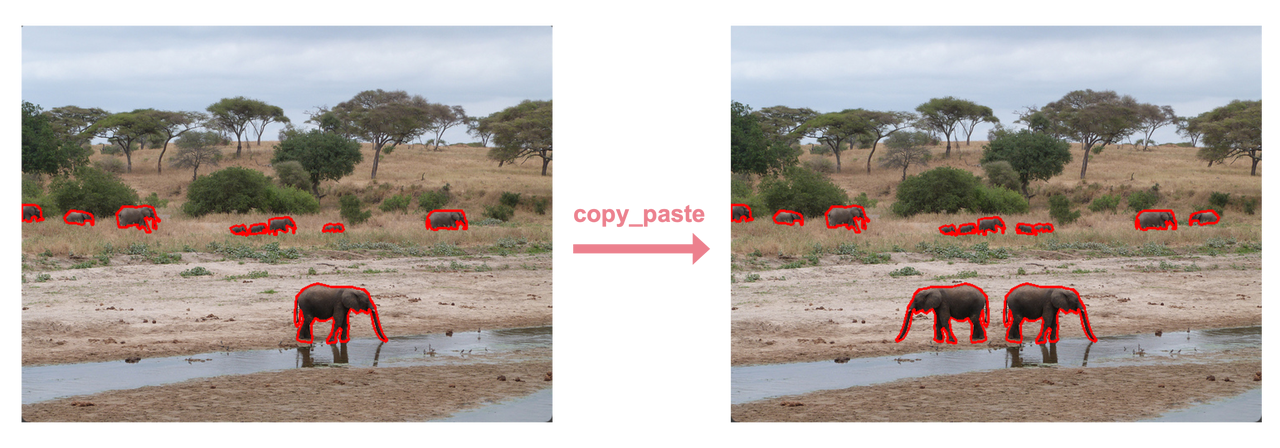

2）更常用的是 ：将 一张图像中的物体 copy 出来，paste 到另外一张图像中

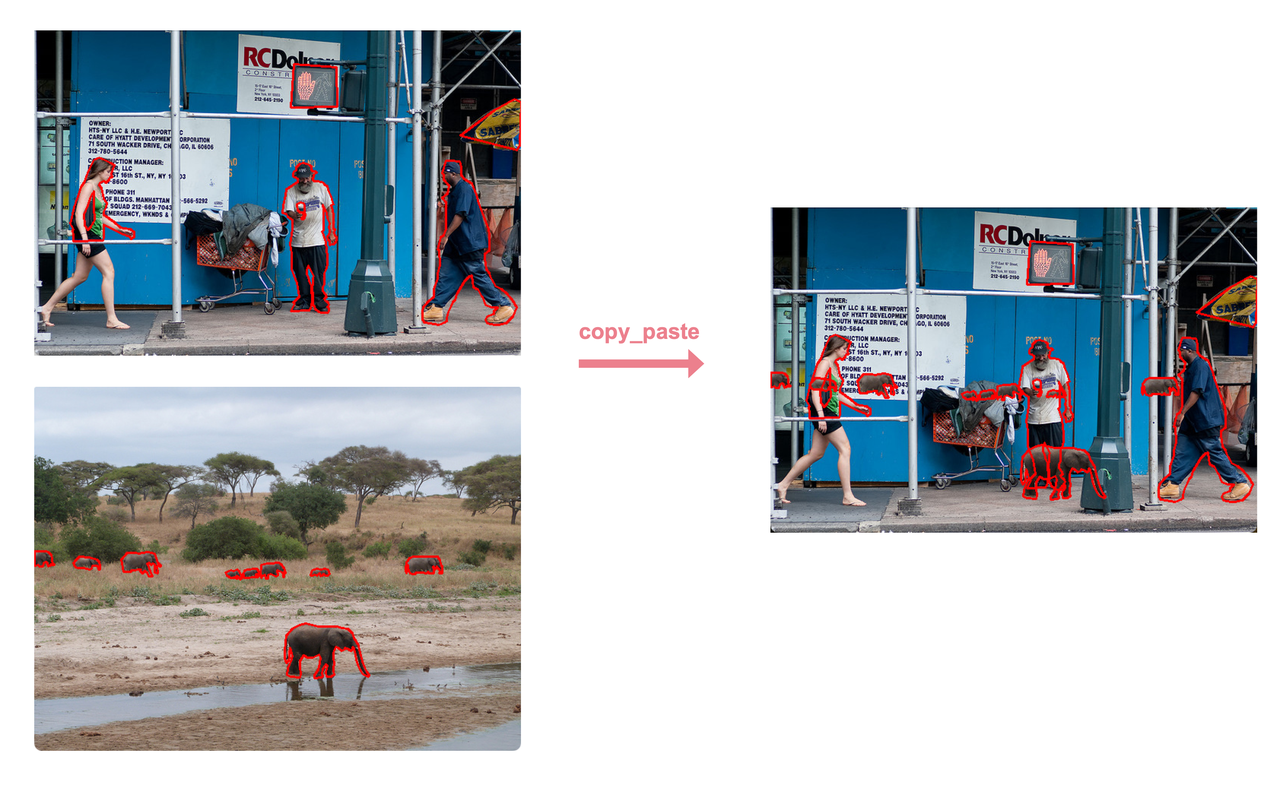

# 2、代码示例
例 1、将一张图像中的物体 copy 出来，paste 在本图像中 

代码说明

按照指定比例 copy-paste 图像中的部分 object， 比如，一张图像中有 10个 object，设置的 copy-paste 概率为 0.5，那么将有 大概5个物体会被 copy-paste

将图片镜像 并从中 copy 出 (镜像的) object，如果 (镜像的) object 的 bbox 与 原图像中的任意一个 bbox 交集面积 都不大于 0.3，则将 (镜像的) object paste 到另外一张图像中

bbox 和 segmentation 标注也要进行合并

In [ ]:
import numpy as np
import random
import torch
from pycocotools.coco import COCO
import math
import cv2

dataDir = '/Users/enzo/Documents/GitHub/prepare/dataset/COCO2017'
annFile = '{}/annotations/instances_val2017.json'.format(dataDir)
imgFile = '{}/val2017'.format(dataDir)

img_size = 640

def bbox_ioa(box1, box2, eps=1e-7):
    """
    Returns the intersection over box2 area given box1, box2.

    Boxes are x1y1x2y2
    box1:       np.array of shape(4)
    box2:       np.array of shape(nx4)
    returns:    np.array of shape(n)
    """

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1
    b2_x1, b2_y1, b2_x2, b2_y2 = box2.T

    # Intersection area
    inter_area = (np.minimum(b1_x2, b2_x2) - np.maximum(b1_x1, b2_x1)).clip(0) * (
        np.minimum(b1_y2, b2_y2) - np.maximum(b1_y1, b2_y1)
    ).clip(0)

    # box2 area
    box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1) + eps

    # Intersection over box2 area
    return inter_area / box2_area


def copy_paste(im, labels, segments, p=0.5):
    """
    Applies Copy-Paste augmentation by flipping and merging segments and labels on an image.
    Details at https://arxiv.org/abs/2012.07177.
    """
    n = len(segments)

    if p and n:
        h, w, c = im.shape  # height, width, channels
        im_new = np.zeros(im.shape, np.uint8)
        for j in random.sample(range(n), k=round(p * n)):
            l, s = labels[j], segments[j]
            box = w - l[3], l[2], w - l[1], l[4]
            ioa = bbox_ioa(box, labels[:, 1:5])  # intersection over area
            if (ioa < 0.30).all():  # allow 30% obscuration of existing labels
                labels = np.concatenate((labels, [[l[0], *box]]), 0)
                segments.append(np.concatenate((w - s[:, 0:1], s[:, 1:2]), 1))
                cv2.drawContours(im_new, [segments[j].astype(np.int32)], -1, (1, 1, 1), cv2.FILLED)

        result = cv2.flip(im, 1)  # augment segments (flip left-right)
        i = cv2.flip(im_new, 1).astype(bool)
        im[i] = result[i]

    return im, labels, segments


if __name__ == '__main__':

    coco = COCO(annFile)
    indices = range(len(coco.imgs))

    file_names = []
    labels = []
    segments = []
    for i in coco.imgs:
        file_names.append(coco.imgs[i]['file_name'])
        img_w, img_h = coco.imgs[i]['width'], coco.imgs[i]['height']

        labels_one_img = []
        segments_one_img = []
        for ann in coco.imgToAnns[i]:
            if ann['iscrowd'] == 0:
                category_id = ann['category_id']
                bbox_xywh = ann['bbox']
                bbox_xyxy = bbox_xywh[0], bbox_xywh[1], bbox_xywh[0]+bbox_xywh[2], bbox_xywh[1]+bbox_xywh[3]
                labels_one_img.append(np.array([category_id, *bbox_xyxy]))

                segmentation = np.array(ann['segmentation'][0]).reshape((-1, 2))
                segments_one_img.append(segmentation)

        labels.append(np.array(labels_one_img))
        segments.append(segments_one_img)

    # 随便指定一张图像
    index = 46
    img_original = cv2.imread(imgFile + '/' + file_names[index])

    one_img_labels = labels[index]
    one_img_segments = segments[index]
    img, one_img_labels, one_img_segments = copy_paste(img_original, one_img_labels, one_img_segments, p=0.5)

    # # 可视化 segmentation
    # for seg in one_img_segments:
    #     points = np.array(seg).reshape((-1, 2)).astype(np.int32)
    #     cv2.drawContours(img, [points], -1, (0, 0, 255), thickness=2)

    # # 可视化 bbox
    # for rect in one_img_labels:
    #     cv2.rectangle(img, (int(rect[1]), int(rect[2])), (int(rect[3]), int(rect[4])), color=(0, 0, 255), thickness=2)

    cv2.imshow('img', img)
    cv2.waitKey()
    cv2.destroyAllWindows()

例 2、将 一张图像中的物体 copy 出来，paste 到另外一张图像中

按照指定比例 copy 图像1 中的部分 object，paste 到图像2中， 比如，图像1 中有 10个 object，设置的 copy-paste 概率为 0.5，那么将有 大概5个物体会被 paste 到图像2中

如果图像1中的物体的 bbox 与 图像2 中的任意一个 bbox 交集面积 都不大于 0.3，则将图片1 中的物体 copy-paste 到图像2中

bbox 和 segmentation 标注也要进行合并

In [ ]:
import numpy as np
import random
import torch
from pycocotools.coco import COCO
import math
import cv2

dataDir = '/Users/enzo/Documents/GitHub/prepare/dataset/COCO2017'
annFile = '{}/annotations/instances_val2017.json'.format(dataDir)
imgFile = '{}/val2017'.format(dataDir)

img_size = 640

def bbox_ioa(box1, box2, eps=1e-7):
    """
    Returns the intersection over box2 area given box1, box2.

    Boxes are x1y1x2y2
    box1:       np.array of shape(4)
    box2:       np.array of shape(nx4)
    returns:    np.array of shape(n)
    """

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1
    b2_x1, b2_y1, b2_x2, b2_y2 = box2.T

    # Intersection area
    inter_area = (np.minimum(b1_x2, b2_x2) - np.maximum(b1_x1, b2_x1)).clip(0) * (
        np.minimum(b1_y2, b2_y2) - np.maximum(b1_y1, b2_y1)
    ).clip(0)

    # box2 area
    box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1) + eps

    # Intersection over box2 area
    return inter_area / box2_area


def copy_paste(img_1, img1_labels, img1_segments, img_2, img2_labels, img2_segments, p=0.5):
    """
    Applies Copy-Paste augmentation by flipping and merging segments and labels on an image.
    Details at https://arxiv.org/abs/2012.07177.
    将 img_1 中的 object copy-paste 到 img_2 中
    """
    n = len(img1_segments)

    if p and n:
        img_1_h, img_1_w, _ = img_1.shape
        img_2_h, img_2_w, _ = img_2.shape
        min_h, min_w = min(img_1_h, img_2_h), min(img_1_w, img_2_w)
        img_mask = np.zeros((min_h, min_w, 3), np.uint8)

        for j in random.sample(range(n), k=round(p * n)):
            l, s = img1_labels[j], img1_segments[j]
            ioa = bbox_ioa(l[1:5], img2_labels[:, 1:5])  # intersection over area
            if (ioa < 0.30).all():  # allow 30% obscuration of existing labels
                # 边界情况要再处理一下
                img2_labels = np.concatenate((img2_labels, [l]), 0)
                img2_segments.append(s)
                cv2.drawContours(img_mask, [img1_segments[j].astype(np.int32)], -1, (1, 1, 1), cv2.FILLED)

        img_mask = img_mask.astype(bool)
        img_2[:min_h, :min_w, :][img_mask] = img_1[:min_h, :min_w, :][img_mask]

    return img_2, img2_labels, img2_segments


if __name__ == '__main__':

    coco = COCO(annFile)
    indices = range(len(coco.imgs))

    file_names = []
    labels = []
    segments = []
    for i in coco.imgs:
        file_names.append(coco.imgs[i]['file_name'])
        img_w, img_h = coco.imgs[i]['width'], coco.imgs[i]['height']

        labels_one_img = []
        segments_one_img = []
        for ann in coco.imgToAnns[i]:
            if ann['iscrowd'] == 0:
                category_id = ann['category_id']
                bbox_xywh = ann['bbox']
                bbox_xyxy = bbox_xywh[0], bbox_xywh[1], bbox_xywh[0]+bbox_xywh[2], bbox_xywh[1]+bbox_xywh[3]
                labels_one_img.append(np.array([category_id, *bbox_xyxy]))

                segmentation = np.array(ann['segmentation'][0]).reshape((-1, 2))
                segments_one_img.append(segmentation)

        labels.append(np.array(labels_one_img))
        segments.append(segments_one_img)

    # 随便指定2张图像
    index = [46, 2]
    img_1 = cv2.imread(imgFile + '/' + file_names[index[0]])
    img_2 = cv2.imread(imgFile + '/' + file_names[index[1]])

    # 第 1 张图像中的 labels 和 segmentations
    img1_labels = labels[index[0]]
    img1_segments = segments[index[0]]

    # 第 2 张图像中的 labels 和 segmentations
    img2_labels = labels[index[1]]
    img2_segments = segments[index[1]]

    img_2, img2_labels, img2_segments = copy_paste(img_1, img1_labels, img1_segments, img_2, img2_labels, img2_segments, p=1)

    # 可视化 segmentation
    for seg in img2_segments:
        points = np.array(seg).reshape((-1, 2)).astype(np.int32)
        cv2.drawContours(img_2, [points], -1, (0, 0, 255), thickness=2)

    # # 可视化 bbox
    # for rect in img2_labels:
    #     cv2.rectangle(img_2, (int(rect[1]), int(rect[2])), (int(rect[3]), int(rect[4])), color=(0, 0, 255), thickness=2)

    cv2.imshow('copy-paste img', img_2)
    cv2.waitKey()
    cv2.destroyAllWindows()